In [15]:
import pandas as pd
import os
import re
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def load_data(data_name, study_name, run_num_list):
    """
    Load data from multiple CSV files in nested directories
    """
    base_path = os.path.join('..', 'data', 'processed_data', study_name)
    source_files = []

    print(f"searching in: {base_path}")

    for root, dirs, files in os.walk(base_path):
        print(files)
        for file in files:
            # Check if the file matches our pattern (e.g., "games.csv")
            if file == f"{data_name}.csv":
                # Get the run number from the path
                run_folder = os.path.basename(root)  # This gets the immediate parent folder name
                if any(run_folder.endswith(run_num) for run_num in run_num_list):
                    full_path = os.path.join(root, file)
                    source_files.append(full_path)
    
    print(f"Source files found for {data_name}:", source_files)
    
    if not source_files:
        print(f"Warning: No files found for {data_name}")
        return pd.DataFrame()
    
    # Read and concatenate all found CSV files
    dfs = []
    for file in source_files:
        try:
            df = pd.read_csv(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def load_and_prepare_data(study_name, run_num_list):
    """
    Load and prepare chat and rounds data, filtering for relevant messages
    """
    # Load both datasets
    d_chat = load_data("chats", study_name, run_num_list)
    d_round = load_data("rounds", study_name, run_num_list)
    
    # Merge chat data with rounds
    d_chat_clean = d_chat.merge(d_round[['roundID', 'gameID']], on='roundID', how='left')
    
    # Filter out chit-chat messages first
    d_chat_clean = d_chat_clean[d_chat_clean['chit_chat'] != True]

    return d_chat_clean

def clean_text(text):
    """Clean text by removing punctuation and extra whitespace"""
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

In [17]:
def compute_message_similarities(df):
    """
    Compute similarities between messages within the same game
    Returns both a DataFrame with upper triangle pairs and full similarity matrices per game
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    similarities_list = []
    similarity_matrices = {}  # Dictionary to store full matrices by game
    
    for game_id, game_df in df.groupby('gameID'):
        print(f"processing: {game_id}")
        texts = game_df['text'].tolist()
        embeddings = model.encode(texts)
        
        # Create full similarity matrix for this game
        n_messages = len(texts)
        sim_matrix = np.zeros((n_messages, n_messages))
        
        # Create pairs of messages and compute similarities
        for i in range(len(texts)):
            for j in range(i + 1, len(texts)):  # Upper triangle for DataFrame
                sim_value = float(model.similarity(
                    embeddings[i].reshape(1, -1), 
                    embeddings[j].reshape(1, -1)
                ))
                
                # Store in upper triangle list for DataFrame
                similarity = {
                    'gameID': game_id,
                    'roundID1': game_df.iloc[i]['roundID'],
                    'roundID2': game_df.iloc[j]['roundID'],
                    'playerID1': game_df.iloc[i]['playerID'],
                    'playerID2': game_df.iloc[j]['playerID'],
                    'text1': texts[i],
                    'text2': texts[j],
                    'similarity': sim_value
                }
                similarities_list.append(similarity)
                
                # Store in full matrix
                sim_matrix[i,j] = sim_value
                sim_matrix[j,i] = sim_value  # Mirror value
        
        # Add diagonal of 1s for self-similarity
        np.fill_diagonal(sim_matrix, 1.0)
        
        # Store matrix with its round/player IDs for reference
        similarity_matrices[game_id] = {
            'matrix': sim_matrix,
            'roundIDs': game_df['roundID'].tolist(),
            'playerIDs': game_df['playerID'].tolist()
        }
    
    return pd.DataFrame(similarities_list), similarity_matrices

In [18]:
study_run_name = "run_v3"
run_num = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", 
           "11", "12", "13", 
           "14-0", "14-1", "14-2", "14-3", 
           "15-0", "15-1", "15-2", 
           "16-0", "16-1", "16-2", 
           "17-0", "17-1", "17-2",
           "18-0", "18-1", "19-0", "19-1",
           "20-0", "20-1", "20-2", "20-3", "20-4", "20-5",
           "21-0", "21-1", "21-2"]
output_path = os.path.join('..', 'data', 'processed_data', 'message_similarities.csv')

In [19]:
chat_db = load_and_prepare_data(study_run_name, run_num)

searching in: ../data/processed_data/run_v3
['.DS_Store']
['rounds.csv', 'players.csv', 'games.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player_bonuses.csv', 'chats.csv']
['rounds.csv', 'players.csv', 'games.csv', 'player

In [20]:
director_counts = chat_db[chat_db['director_msg'] == True].groupby('roundID')['playerID'].nunique()

if any(director_counts > 2):
    print("Warning: Found rounds with more than two directors!")
    problematic_rounds = director_counts[director_counts > 2].index
    print(f"Problematic round IDs: {problematic_rounds.tolist()}")

In [21]:
chat_db['text'] = chat_db['text'].apply(clean_text)

director_chat_db = chat_db[chat_db['director_msg'] == True]

In [22]:
director_chat_db

,roundID,text,playerID,director_msg,chit_chat,gameID
0,01JK45JY89DT9DJF1J0K7ZME35,castle with diamond in the middle,01JK457AKRPRNS17AEQHS80T3S,True,False,01JK44ZDN4WND3M57SJYNVDKAJ
1,01JK45JY8CTCKTW44WVGHFD058,house all black,01JK455VW63ETCXWJFGJTK6P5P,True,False,01JK44ZDN4WND3M57SJYNVDKAJ
2,01JK47RT60A49SXAMT1K2GJCED,small sharp hat on top of a pointy blob,01JK47J0RF2VM23CA4CWE4AVRX,True,False,01JK44ZG88WSKH56Z2TG065NRD
3,01JK48HH7AP0B8HA05A4S3C7VJ,top arrow facing the right and bottom two arro...,01JK4847PY2ET4C6DNW9N77HM7,True,False,01JK44ZH7ME8SPE3ZCXE9C1EDR
4,01JK48HH7JJXV8DQKAMVDKAF4D,dogs ears top and arrow facing right,01JK4803HNF7SME8Z9W0HT6DBY,True,False,01JK44ZH7ME8SPE3ZCXE9C1EDR
...,...,...,...,...,...,...
44528,01JHK1C8HCWJGP2G9XFPQBPXJ9,zigzag top and bottom look like feet walking,01JHK12Q0A1QP5WE7N07P9FEKS,True,False,01JHK109ZZFWSNN1EJS7PDWT9M
44530,01JHK1CBMK05XTAQ97SQRBFJ28,zigzag top one point bottom,01JHK12Q0A1QP5WE7N07P9FEKS,True,False,01JHK109ZZFWSNN1EJS7PDWT9M
44531,01JHK1CBJ4RA9B5ZT4CQCKJZ27,zigzag top tiangle bottom,01JHK12Q0A1QP5WE7N07P9FEKS,True,False,01JHK109ZZFWSNN1EJS7PDWT9M
44532,01JHK1CB3DFQQ51MVF9N0MYC4D,zigzag top 3 legs bottom,01JHK12Q0A1QP5WE7N07P9FEKS,True,False,01JHK109ZZFWSNN1EJS7PDWT9M


In [23]:
collapsed = director_chat_db.groupby(['gameID', 'roundID', 'playerID', 'director_msg']).agg({
        'text': lambda x: ', '.join(x)
    }).reset_index()

In [24]:
any(collapsed.groupby('roundID').size()) > 1

False

In [25]:
similarities_df, similarities_matrices = compute_message_similarities(collapsed)

processing: 01JGMPDZ42BSHFVYVY6M672P0G
processing: 01JGMPDZ43FFD9JRQ4A4DMTRA1
processing: 01JGMPDZ43FFD9JRQ4AJG1MR0F
processing: 01JGMPE587BR7N7WSVT2WDGBYZ
processing: 01JGMPE5881R3V1FHKJHHTTK7K
processing: 01JGMPEGCCTMJ7086RP1QDWA0E
processing: 01JGMPEGCD0EX4TXSSNEY3A670
processing: 01JGMPEGCD0EX4TXSSNR8YRX74
processing: 01JGMPEKWGHHVPTB7Y1WE4VE72
processing: 01JGMPEKWGHHVPTB7Y2D6260DM
processing: 01JGMPEKWH8QMTD4WJEC8GZVHA
processing: 01JGZ1HQ3BXW69RFKVBQ3Y8K4V
processing: 01JGZ1HQ3BXW69RFKVC55KXV7B
processing: 01JGZ1HQ3D5SE9KTKE87QW9STN
processing: 01JGZ1J1S9HRZETTFT0YBZ9QYK
processing: 01JGZ1J1SAQ65EVEEREPVNZ6VV
processing: 01JGZ1J4WKTCRGQS8R8214JJH2
processing: 01JGZ1J4WKTCRGQS8R8HDNJ96R
processing: 01JGZ1J4WMY7MA81TRZB8H2YG3
processing: 01JGZ1J6QWPAFKR4CPC25F4W67
processing: 01JGZ1J6QWPAFKR4CPC8THA3K7
processing: 01JGZ1J6QX7N1Q5REWV6S61X60
processing: 01JGZ1JTFN1FD5A54BCQMJHBNZ
processing: 01JGZ1JTFPNZ10B2SXAYHEV9EZ
processing: 01JGZ1JTFPNZ10B2SXBEYNMS9G
processing: 01JGZ1JZ8NW40

In [26]:
similarities_df.to_csv(output_path, index=False)

In [27]:
similarities_df

,gameID,roundID1,roundID2,playerID1,playerID2,text1,text2,similarity
0,01JGMPDZ42BSHFVYVY6M672P0G,01JGMQN9RQ4D7YX3FJE80H2FZM,01JGMQN9RSH49YN5E5K925RRMT,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,01JGMQGPZBFPBPR8RRNHWD81EA,"object is symmetrical on the horizontal axis, ...","right side is one large shape, left side has w...",0.612724
1,01JGMPDZ42BSHFVYVY6M672P0G,01JGMQN9RQ4D7YX3FJE80H2FZM,01JGMQN9T05V3E4JQKH1P67BGP,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,01JGMQGPZBFPBPR8RRNHWD81EA,"object is symmetrical on the horizontal axis, ...","right side is one large shape, left side has s...",0.372527
2,01JGMPDZ42BSHFVYVY6M672P0G,01JGMQN9RQ4D7YX3FJE80H2FZM,01JGMQN9T1M8Z9QA7Z94H5WAH2,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,01JGMQGPZBFPBPR8RRNHWD81EA,"object is symmetrical on the horizontal axis, ...",right side looks like a spool for wire has 4 s...,0.225023
3,01JGMPDZ42BSHFVYVY6M672P0G,01JGMQN9RQ4D7YX3FJE80H2FZM,01JGMQN9T23ZDBMMT59KZVZPJT,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,"object is symmetrical on the horizontal axis, ...",left side looks like a cup right side is one b...,0.302767
4,01JGMPDZ42BSHFVYVY6M672P0G,01JGMQN9RQ4D7YX3FJE80H2FZM,01JGMQN9T3C2E5GYYH0ZQ7RW5B,01JGMQH1FMA0SZ0ZMDHAFWQJ3A,01JGMQGPZBFPBPR8RRNHWD81EA,"object is symmetrical on the horizontal axis, ...",right side looks like a jar to me has 4 sharp ...,0.253653
...,...,...,...,...,...,...,...,...
970804,01JK4RQPBEH5ADW6QYMXY80TY6,01JK4SE2GSRJ7YMT65R3643WA2,01JK4SE2GV4YMCA053H0WG2ZHP,01JK4S3JEE861EJG5REXZ7DHQ3,01JK4S4RPKNJ360G99P4GQ0YR1,music stand with page to th eleft,pig,-0.017228
970805,01JK4RQPBEH5ADW6QYMXY80TY6,01JK4SE2GSRJ7YMT65R3643WA2,01JK4SE2GWQ4H727VTGFWQ1P49,01JK4S3JEE861EJG5REXZ7DHQ3,01JK4S3JEE861EJG5REXZ7DHQ3,music stand with page to th eleft,crown on top traingel bottom,0.203229
970806,01JK4RQPBEH5ADW6QYMXY80TY6,01JK4SE2GTXASRCDGA7RSKFQE8,01JK4SE2GV4YMCA053H0WG2ZHP,01JK4S4RPKNJ360G99P4GQ0YR1,01JK4S4RPKNJ360G99P4GQ0YR1,bookshelf,pig,0.229704
970807,01JK4RQPBEH5ADW6QYMXY80TY6,01JK4SE2GTXASRCDGA7RSKFQE8,01JK4SE2GWQ4H727VTGFWQ1P49,01JK4S4RPKNJ360G99P4GQ0YR1,01JK4S3JEE861EJG5REXZ7DHQ3,bookshelf,crown on top traingel bottom,0.090693


['01JGMPDZ42BSHFVYVY6M672P0G', '01JGMPDZ43FFD9JRQ4A4DMTRA1', '01JGMPDZ43FFD9JRQ4AJG1MR0F', '01JGMPE587BR7N7WSVT2WDGBYZ', '01JGMPE5881R3V1FHKJHHTTK7K', '01JGMPEGCCTMJ7086RP1QDWA0E', '01JGMPEGCD0EX4TXSSNEY3A670', '01JGMPEGCD0EX4TXSSNR8YRX74', '01JGMPEKWGHHVPTB7Y1WE4VE72', '01JGMPEKWGHHVPTB7Y2D6260DM', '01JGMPEKWH8QMTD4WJEC8GZVHA', '01JGZ1HQ3BXW69RFKVBQ3Y8K4V', '01JGZ1HQ3BXW69RFKVC55KXV7B', '01JGZ1HQ3D5SE9KTKE87QW9STN', '01JGZ1J1S9HRZETTFT0YBZ9QYK', '01JGZ1J1SAQ65EVEEREPVNZ6VV', '01JGZ1J4WKTCRGQS8R8214JJH2', '01JGZ1J4WKTCRGQS8R8HDNJ96R', '01JGZ1J4WMY7MA81TRZB8H2YG3', '01JGZ1J6QWPAFKR4CPC25F4W67', '01JGZ1J6QWPAFKR4CPC8THA3K7', '01JGZ1J6QX7N1Q5REWV6S61X60', '01JGZ1JTFN1FD5A54BCQMJHBNZ', '01JGZ1JTFPNZ10B2SXAYHEV9EZ', '01JGZ1JTFPNZ10B2SXBEYNMS9G', '01JGZ1JZ8NW40KBCX0V187VCKF', '01JGZ1JZ8NW40KBCX0V75X3ASW', '01JGZ1JZ8NW40KBCX0VGZ5C48M', '01JGZ2J71XN8Q7J627EBMRDRH5', '01JGZ2J7237RK699F2RP9MBZAC', '01JH0YPC4NS99AQ4RGT50WE76D', '01JH0YPC4PQ2SZZT98DCX2XKP3', '01JH0YPC4R1XMMR506PW3T899B', '01JH0YW8

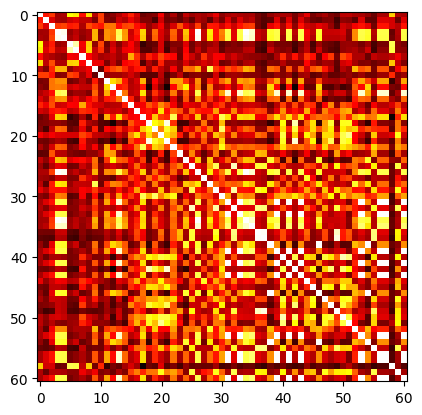

In [28]:
games = list(similarities_matrices.keys())
print(games)
sim = similarities_matrices[games[16]]['matrix']

plt.imshow(sim, cmap='hot', interpolation='nearest')
plt.show()

In [114]:
normalized_matrices = {}

for game_id, game_data in similarities_matrices.items():
    matrix = game_data['matrix']
    
    # Min-max normalization
    matrix_norm = (matrix - matrix.min()) / (matrix.max() - matrix.min())
    
    # Store normalized matrix along with the reference IDs
    normalized_matrices[game_id] = {
        'matrix': matrix_norm,
        'roundIDs': game_data['roundIDs'],
        'playerIDs': game_data['playerIDs']
    }

/var/folders/qg/6r3y3gfx1g77hnk_4dptznvc0000gn/T/ipykernel_92017/363137246.py:7: RuntimeWarning: invalid value encountered in divide
  matrix_norm = (matrix - matrix.min()) / (matrix.max() - matrix.min())
